# PHYS3116 Tutorial 5: Functions, the IMF and Distance Measures

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.cosmology import FlatLambdaCDM
import astropy.cosmology.units as cu
from astropy import units as u
from scipy.optimize import curve_fit

To start with let's introduce a new Python package, Astropy. As hinted by the name, this package is designed to be used by astronomers. 

In [2]:
# A really useful tool is being able to define units
distance = 30 * u.Mpc
distance

<Quantity 30. Mpc>

In [3]:
time = 20 * u.s
time

<Quantity 20. s>

In [4]:
# --- Define cosmology ---
# lets use some approximate values for now.

H0 = 70 # Hubble constant
Om0 = 0.3 # Present day matter desnity


cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
print(cosmo)

FlatLambdaCDM(H0=70.0 km / (Mpc s), Om0=0.3, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=None)


In [5]:
# we can use this cosmology to get particular properties at a specified redshift
z = 0.30
cosmo.age(z)

<Quantity 10.04867469 Gyr>

In [6]:
# what is the look back time at this redshift?

cosmo.age(0) - cosmo.age(z)

<Quantity 3.41830925 Gyr>

In [7]:
# Can also do for an array of redshifts

cosmo.age([0.5, 1, 1.5] * cu.redshift)

<Quantity [8.42634602, 5.75164694, 4.20073193] Gyr>

In [8]:
# we can also find distances
cosmo.comoving_distance(0)

<Quantity 0. Mpc>

In [9]:
# how are away is that object from us now?
cosmo.comoving_distance(z)

<Quantity 1194.39686972 Mpc>

# Exercises

## 1) Plotting Distances
#### a) Imagine you have a 10 spectra containing the $H\alpha$ line. Across these spectra you find that the $H\alpha$ line varies between 7,000 and 12,000 Angstroms. Recall that at z = 0,  $\lambda_{H\alpha, rest}$ = 6,563 Angstroms. Pretend that the 10 $H\alpha$ lines are evenly spaced between 7,000 and 12,000 Angstroms. Make a plot of $\lambda_{H\alpha, obs}$ - $\lambda_{H\alpha, rest}$ vs Distance to the object emmitting the spectra. You must use functions to do this where one of the inputs is the array of $\lambda_{H\alpha}$ wavelengths and the output is the distances.

#### b) Using the fitting_func and scipy.curve_fit, fit a curve to the data

#### b) Pretend that the telescope can only resolve wavelengths up to (and including) 8,000 Angstroms. What is the largest lookback time that we can observe at resolution.

Text(0, 0.5, 'Comoving Distance (Mpc)')

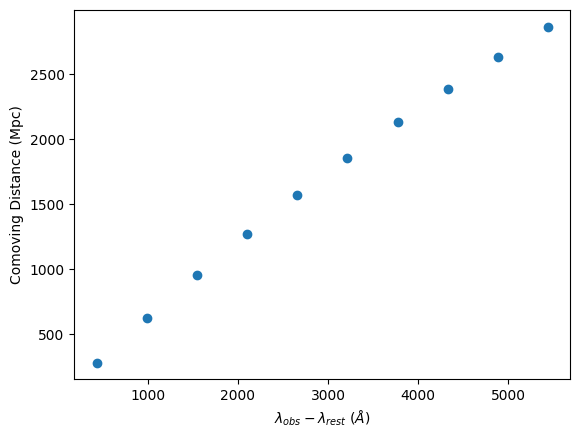

In [79]:
# 1a)

# --- Define cosmology ---
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

lambda_rest = 6563
lambda_obs_array = np.linspace(7000, 12000, 10)

def get_get_distances(lambda_obs, lambda_rest, cosmo):
    z = (lambda_obs - lambda_rest) / lambda_rest
    dist = cosmo.comoving_distance(z * cu.redshift)

    return dist

distances = get_get_distances(lambda_obs_array, lambda_rest, cosmo)

plt.scatter(lambda_obs_array - lambda_rest, distances)
plt.xlabel(r"$\lambda_{obs} - \lambda_{rest}$ $(\AA)$")
plt.ylabel("Comoving Distance (Mpc)")

In [80]:
# 1b)

def fitting_func(lambda_obs, a, b, lambda_rest=6563):
    z = (lambda_obs / lambda_rest) - 1
    return a * (z / (1 - b * z))

In [76]:
# popt returns values of a, b used in the fitting_func. pcov is the covariance (error) matrix on the a, b values

popt, pcov = curve_fit(fitting_func, lambda_obs_array, distances, p0=[4000, 0.5])

popt, pcov

(array([ 4.36019502e+03, -3.12535352e-01]),
 array([[ 1.19627443e+02, -4.94086626e-02],
        [-4.94086626e-02,  2.15910509e-05]]))

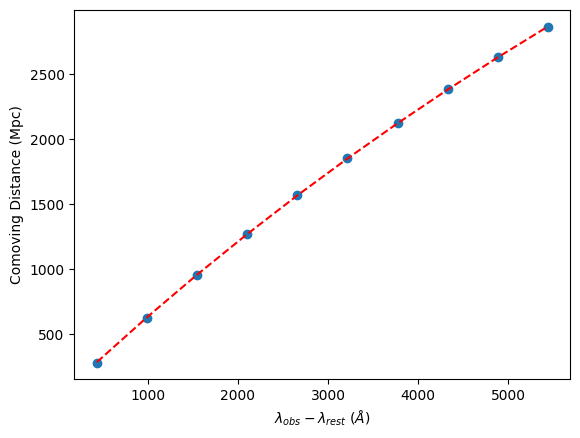

In [77]:
plt.scatter(lambda_obs_array - lambda_rest, distances)
plt.xlabel(r"$\lambda_{obs} - \lambda_{rest}$ $(\AA)$")
plt.ylabel("Comoving Distance (Mpc)")

fitted_distances = fitting_func(lambda_obs_array, *popt)
plt.plot(lambda_obs_array - lambda_rest, fitted_distances, color='red', linestyle='--', label="Fit")

In [83]:
# 1c)

z = (8000 - lambda_rest) / lambda_rest
cosmo.age(0) - cosmo.age(z)

<Quantity 2.62930846 Gyr>

# Exercises

## 1) Plotting the Salpeter IMF
#### a) Again using functions, plot the salpeter IMF as a function of mass reminder that Function $\propto m^{-2.35}$ for range (0.1Msol - 100Msol)
#### b) Calculate the fraction of the total stellar mass in our galaxy being formed at any one time that is contained in: Stars with mass between 0.1Msol and 0.3Msol (hint: total_mass = np.trapz(m * xi, m))

In [ ]:
# 2a)

def salpeter_imf(m, alpha=2.35):
    """
    Salpeter IMF: xi(m) ∝ m^(-alpha)
    m : stellar mass [Msun]
    alpha : slope
    Returns xi(m)
    """
    return m**(-alpha)

Text(0, 0.5, 'IMF $\\xi(m)$')

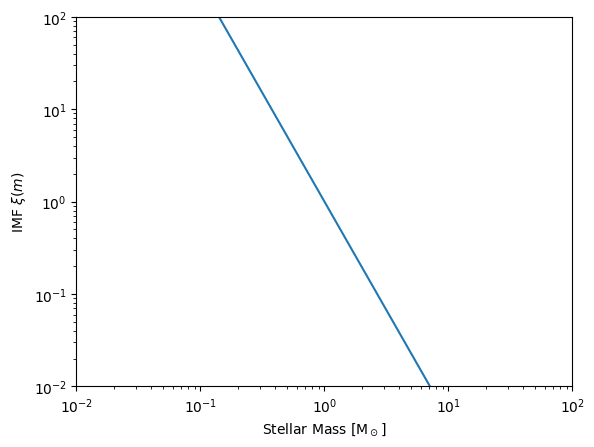

In [100]:
m = np.logspace(-1, 2, 1000)
xi = salpeter_imf(m)

plt.plot(m, xi)

plt.xscale("log")
plt.yscale("log")

plt.xlim(1e-2, 1e2)
plt.ylim(1e-2, 1e2)

plt.xlabel("Stellar Mass [M$_\odot$]")
plt.ylabel(r"IMF $\xi(m)$")

In [101]:
# --- Mass fraction function using np.trapz ---
def mass_fraction(m, m_min, m_max, alpha=2.35):
    """
    Fraction of total stellar mass in [m_min, m_max] using trapezoidal integration.
    """
    # generate mass array
    xi = salpeter_imf(m, alpha)
    
    # total mass
    total_mass = np.trapz(m * xi, m)
    
    # mass in range
    mask = (m >= m_min) & (m <= m_max)
    mass_in_range = np.trapz(m[mask] * xi[mask], m[mask])
    
    # fraction
    frac = mass_in_range / total_mass
    return frac

In [102]:
mass_fraction(m, 0.1, 0.3)

0.3488570110301268